# Отток клиентов

# Customer churn

Каждый месяц , в небольших количествах, из банка банка уходят клиенты. Маркетологи проанализировав ситуацию, поняли, что сохранять клиентов дешевле, чем привлекать новых.
Необходимо построить модель, на основе исторических данных, способную предсказать уйдет ли клиент. Используемая метрика: F1-мера, которую нужно довести как минимум до 0.59. Также необходимо построить AUC-ROC кривую и сравнить ее с F-1 мерой.

Every month, in small quantities, customers leave the bank of the bank. After analyzing the situation, marketers realized that retaining customers is cheaper than attracting new ones.
It is necessary to build a model based on historical data that can predict whether the client will leave. Metric used: F1-measure to be brought up to at least 0.59. It is also necessary to plot the AUC-ROC curve and compare it with the F-1 measure.

# Оглавление.

- [Шаг 1. Подготовка данных.](#Step_1) <br />
[1.1. Загрузка данных и первое знакомство с ними.](#Step_2) <br />
[1.2. Подготовка данных.](#Step_3) <br />
- [Шаг 2. Исследование задачи.](#Step_4) <br />
[2.1. Решающее дерево.](#Step_5) <br />
[2.2. Случайный лес.](#Step_6) <br />
[2.2. Логистическая регрессия.](#Step_7) <br />
- [Шаг 3. Борьба с дисбалансом.](#Step_8)<br />
[3.1. Взвешивание классов.](#Step_9) <br />
[3.2. Upsampling.](#Step_10) <br />
[3.3. Downsampling.](#Step_11) <br />
- [Шаг 4. Тестирование модели.](#Step_12)<br />


# Table of contents.

- [Step 1. Data preparation.](#Step_1) <br />
[1.1. Loading data and getting to know it for the first time.](#Step_2) <br />
[1.2. Data preparation.](#Step_3) <br />
- [Step 2. Research the problem.](#Step_4) <br />
[2.1. Decision tree.](#Step_5) <br />
[2.2. Random forest.](#Step_6) <br />
[2.2. Logistic regression.](#Step_7) <br />
- [Step 3. Dealing with imbalance.](#Step_8)<br />
[3.1. Class weighting.](#Step_9) <br />
[3.2. Upsampling.](#Step_10) <br />
[3.3. Downsampling.](#Step_11) <br />
- [Step 4. Model testing.](#Step_12)<br />

<a id='Step_1'></a>
# 1. Подготовка данных

<a id='Step_2'></a>
### 1.1. Загрузка данных и первое знакомство с ними.

### 1.1. Loading data and getting to know it for the first time.

Загружаем библиотеки.

Loading libraries.

In [ ]:
import pandas as pd
import numpy as np
import math 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score 
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.preprocessing import StandardScaler 

In [ ]:
from sklearn.metrics import recall_score

Загружаем файл.

Uploading a file.

In [ ]:
df = pd.read_csv('/datasets/Churn.csv')

Посмотрим на общую информацию.

Let's look at general information.

In [ ]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Посмотрим нет ли дубликатов строк и не записан ли какой-нибудь клиент дважды.

Let's see if there are any duplicate lines and if any client is recorded twice.

In [ ]:
print(df.duplicated().sum())
print(df.duplicated('CustomerId').sum())

0
0


Дубликатов нет.

There are no duplicates.

Посмотрим на форматы и пропущенные значения.

Let's look at formats and missing values.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


- RowNumber, CustomerId,  Surname - идентифицируют клиента. Удалим их: нам хватит индексации пондас.
- Geography и Gender - качественные признаки - применим OHE.
- Tenure - может быть только целочисленным - изменим формат на int.
- HasCrCard, IsActiveMember, Exited - должны стать булевыми значениями.

- RowNumber, CustomerId, Surname - identify the customer. Let's delete them: indexing pondas is enough for us.
- Geography and Gender - qualitative features - applicable OHE.
- Tenure - can only be integer - change the format to int.
- HasCrCard, IsActiveMember, Exited - must become boolean values.

Посмотрим на уникальные значения столбца с пропущенными значениями.

Let's look at the unique values of a column with missing values.

In [ ]:
df['Tenure'].unique()

array([ 2.,  1.,  8.,  7.,  4.,  6.,  3., 10.,  5.,  9.,  0., nan])

Заполним nan нулями, предполагая, что имущества у клиента действительно нет.

Let's fill nan with zeros, assuming that the client really does not have any property.

<a id='Step_3'></a>
### 1.2. Подготовка данных.

### 1.2. Data preparation.

In [ ]:
# Удаляем столбцы RowNumber, CustomerId,  Surname.
df.drop(['RowNumber', 'CustomerId',  'Surname'], axis=1, inplace=True)
# Заполняем пропушенные значения в Tenure нулями и меняем ормат на int.
df['Tenure'].fillna(0, inplace=True)
df['Tenure'] = df['Tenure'].astype('int')
# Меняем формат HasCrCard, IsActiveMember, Exited на bool.
df['HasCrCard'] = df['HasCrCard'].astype('bool')
df['IsActiveMember'] = df['IsActiveMember'].astype('bool')
df['Exited'] = df['Exited'].astype('bool')
# Применим OHE к Geography и Gender.
df = pd.get_dummies(df, drop_first=True)
# Выводим результат.
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,True,True,101348.88,True,0,0,0
1,608,41,1,83807.86,1,False,True,112542.58,False,0,1,0
2,502,42,8,159660.80,3,True,False,113931.57,True,0,0,0
3,699,39,1,0.00,2,False,False,93826.63,False,0,0,0
4,850,43,2,125510.82,1,True,True,79084.10,False,0,1,0


Создадим выборки для обучения, валидации и теста, перед этим отделив признаки от целевой переменной.

Let's create samples for training, validation and test, before that, separating the features from the target variable.

In [ ]:
y = df['Exited']
X = df.drop(['Exited'], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

Мы делили выборки в два этапа. На первом мы разделили в пропорции 80% на 20%. Затем нам нужно от 80% отделить еще 20% от первоначальных 100%. Но если просто изъять 20% из оставшихся 80%, то число получится меньше чем нужно, поэтому нам надо было расчитать какой процент от 80% объектов равен 20% от 100% объектов. Для этого мы делим 80% объектов на 20%. Получаем 4. То есть нам нужно взять от 100% четвертую часть, что равно 25%. Результат:

We divided the samples in two stages. At the first, we divided in proportion 80% by 20%. Then we need to separate another 20% from the original 100% from 80%. But if we simply remove 20% of the remaining 80%, then the number will turn out to be less than necessary, so we had to calculate what percentage of 80% of objects is equal to 20% of 100% of objects. To do this, we divide 80% of the objects by 20%. We get 4. That is, we need to take the fourth part from 100%, which is equal to 25%. Result:

In [ ]:
print('X_train', len(X_train))
print('X_valid', len(X_valid))
print('X_test', len(X_test))

X_train 6000
X_valid 2000
X_test 2000


Теперь у нас есть шесть частей сета.
- Обучение: X_train, y_train.
- Валидация: X_valid, y_valid
- Тест: X_test, y_test

Now we have six parts of the set.
- Training: X_train, y_train.
- Validation: X_valid, y_valid
- Test: X_test, y_test

 ### Summary:
 На этом шаге мы познакомились с данными и провели некторые преобразования:
 - заполнили пропуски нулями в стобце Tenure;
 - зрименили OHE к Gender (теперь 1='male', 0='female') и Geography;
 - удалили нативную индексацию, id клиента и его фамилию;
 - привели переменные к нужным форматам.

### Summary:
  At this step, we got acquainted with the data and carried out some transformations:
  - filled in the gaps with zeros in the Tenure column;
  - applied OHE to Gender (now 1='male', 0='female') and Geography;
  - removed native indexing, client id and last name;
  - brought the variables to the required formats.

<a id='Step_4'></a>
# 2. Исследование задачи

# 2. Research the problem

Посмотрим на баланc классов.

Let's look at class balance.

In [ ]:
y_train.value_counts()

False    4777
True     1223
Name: Exited, dtype: int64

В выборке наблюдается дисбаланс классов. На этам шаге нам нужно построить на модели без учета этого факта.

There is a class imbalance in the sample. At this step, we need to build on the model without taking this fact into account.

<a id='Step_5'></a>
### 2.1. Решающее дерево.

### 2.1. Decision tree.

In [ ]:
max_depth_list_tree = []
criterion_list_tree = [] 
result_list_tree = []
for max_depth in range(1,6):
    for criterion in ('gini', 'entropy'):
        model_tree = DecisionTreeClassifier(random_state=42, max_depth=max_depth, criterion=criterion)
        model_tree.fit(X_train, y_train)
        prediction = model_tree.predict(X_valid)
        result = f1_score(y_valid, prediction)
        max_depth_list_tree.append(max_depth)
        criterion_list_tree.append(criterion)
        result_list_tree.append(result)

trees = pd.DataFrame(data={'max_depth' : max_depth_list_tree, 'criterion' : criterion_list_tree, 'result' : result_list_tree})
trees.sort_values(by='result', ascending=False)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,max_depth,criterion,result
9,5,entropy,0.513471
2,2,gini,0.500711
3,2,entropy,0.500711
8,5,gini,0.472973
6,4,gini,0.462585
4,3,gini,0.380952
7,4,entropy,0.355469
5,3,entropy,0.337812
0,1,gini,0.000000
1,1,entropy,0.000000


Маловато F1.

Not enough F1.

<a id='Step_6'></a>
### 2.2. Случайный лес. 

### 2.2. Random forest.

In [ ]:
max_depth_list_forest = []
criterion_list_forest = [] 
n_estimators_list_forest = []
result_list_forest = []
for max_depth in range(1,6):
    for criterion in ('gini', 'entropy'):
        for n_estimators in range(10, 100, 10):
            model_forest = RandomForestClassifier(random_state=42, max_depth=max_depth, criterion=criterion, 
                                                  n_estimators=n_estimators)
            model_forest.fit(X_train, y_train)
            prediction = model_forest.predict(X_valid)
            result = f1_score(prediction, y_valid)
            max_depth_list_forest.append(max_depth)
            criterion_list_forest.append(criterion)
            n_estimators_list_forest.append(n_estimators)
            result_list_forest.append(result)
forest = pd.DataFrame(data={'max_depth' : max_depth_list_forest, 'criterion' : criterion_list_forest, 
                            'n_estimators' : n_estimators_list_forest, 'result' : result_list_forest})
forest.sort_values(by='result', ascending=False).head()

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no tru

,max_depth,criterion,n_estimators,result
81,5,entropy,10,0.473230
72,5,gini,10,0.473043
73,5,gini,20,0.438061
79,5,gini,80,0.437613
80,5,gini,90,0.429872


Тоже F-мера не дотягивает.

Also F-measure falls short.

<a id='Step_7'></a>
### 3.3. Логистическая регрессия.

### 3.3. logistic regression.

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_valid_scaled = scaler.transform(X_valid) 

In [ ]:
model_logit_scale = LogisticRegression(solver='liblinear')
model_logit_scale.fit(X_train_scaled, y_train)
prediction_logit_scale = model_logit_scale.predict(X_valid_scaled)
result = f1_score(prediction_logit_scale, y_valid)
print(result)

0.3135135135135135


Ну а тут совсем мало. 

Well, there is very little.

### Summary:
На этом шаге мы испытали модели: решающее дерево, случайный лес, логистическая регрессия. Без учета дисбаласна. Получили неудоволитворительные результаты. В следующем шаге попробуем улучшить модель, учитывая этот факт. 

### Summary:
At this step, we tested the models: decision tree, random forest, logistic regression. Disregarding imbalance. We got unsatisfactory results. In the next step, we will try to improve the model, taking into account this fact.

<a id='Step_8'></a>
# 3. Борьба с дисбалансом

# 3. Fight imbalance

В нашем распоряжении три интрумента борьбы с дисбалансом:
- взвешивание классов
- upsampling
- downsampling

We have three tools at our disposal to deal with imbalances:
- class weighting
- upsampling
-downsampling

Исходя из опыта полученного на тренажере, я выбираю случайный лес в качестве основной модели для модернизации и дальнейшего использования. 

Based on the experience gained on the simulator, I choose a random forest as the main model for modernization and further use.

<a id='Step_9'></a>
### 3.1. Взвешивание классов.

### 3.1. Class weighting.

In [ ]:
max_depth_list_forest = []
criterion_list_forest = [] 
n_estimators_list_forest = []
result_list_forest = []
for max_depth in range(1,12):
    for criterion in ('gini', 'entropy'):
        for n_estimators in range(10, 100, 10):
            model_forest = RandomForestClassifier(random_state=42, max_depth=max_depth, criterion=criterion, 
                                                  n_estimators=n_estimators, class_weight='balanced')
            model_forest.fit(X_train, y_train)
            prediction = model_forest.predict(X_valid)
            result = f1_score(prediction, y_valid)
            max_depth_list_forest.append(max_depth)
            criterion_list_forest.append(criterion)
            n_estimators_list_forest.append(n_estimators)
            result_list_forest.append(result)
forest = pd.DataFrame(data={'max_depth' : max_depth_list_forest, 'criterion' : criterion_list_forest, 
                            'n_estimators' : n_estimators_list_forest, 'result' : result_list_forest})
forest.sort_values(by='result', ascending=False).head()

,max_depth,criterion,n_estimators,result
165,10,gini,40,0.639024
166,10,gini,50,0.635697
167,10,gini,60,0.634804
177,10,entropy,70,0.634499
149,9,gini,60,0.634033


<a id='Step_10'></a>
### 3.2. Upsampling.

In [ ]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled

X_upsampled, y_upsampled = upsample(X_train, y_train, 4)

In [ ]:
y_upsampled.value_counts()

True     4892
False    4777
Name: Exited, dtype: int64

In [ ]:
max_depth_list_forest = []
criterion_list_forest = [] 
n_estimators_list_forest = []
result_list_forest = []
for max_depth in range(1,12):
    for criterion in ('gini', 'entropy'):
        for n_estimators in range(10, 100, 10):
            model_forest = RandomForestClassifier(random_state=42, max_depth=max_depth, criterion=criterion, 
                                                  n_estimators=n_estimators)
            model_forest.fit(X_upsampled, y_upsampled)
            prediction = model_forest.predict(X_valid)
            result = f1_score(prediction, y_valid)
            max_depth_list_forest.append(max_depth)
            criterion_list_forest.append(criterion)
            n_estimators_list_forest.append(n_estimators)
            result_list_forest.append(result)
forest = pd.DataFrame(data={'max_depth' : max_depth_list_forest, 'criterion' : criterion_list_forest, 
                            'n_estimators' : n_estimators_list_forest, 'result' : result_list_forest})
forest.sort_values(by='result', ascending=False).head()

,max_depth,criterion,n_estimators,result
163,10,gini,20,0.634956
168,10,gini,70,0.634038
166,10,gini,50,0.633333
165,10,gini,40,0.632385
170,10,gini,90,0.631813


<a id='Step_11'></a>
### 3.3. Downsampling.

In [ ]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

X_downsampled, y_downsampled = downsample(X_train, y_train, 0.3)

In [ ]:
y_downsampled.value_counts()

False    1433
True     1223
Name: Exited, dtype: int64

In [ ]:
max_depth_list_forest = []
criterion_list_forest = [] 
n_estimators_list_forest = []
result_list_forest = []
for max_depth in range(1,12):
    for criterion in ('gini', 'entropy'):
        for n_estimators in range(10, 100, 10):
            model_forest = RandomForestClassifier(random_state=42, max_depth=max_depth, criterion=criterion, 
                                                  n_estimators=n_estimators)
            model_forest.fit(X_downsampled, y_downsampled)
            prediction = model_forest.predict(X_valid)
            result = f1_score(prediction, y_valid)
            max_depth_list_forest.append(max_depth)
            criterion_list_forest.append(criterion)
            n_estimators_list_forest.append(n_estimators)
            result_list_forest.append(result)
forest = pd.DataFrame(data={'max_depth' : max_depth_list_forest, 'criterion' : criterion_list_forest, 
                            'n_estimators' : n_estimators_list_forest, 'result' : result_list_forest})
forest.sort_values(by='result', ascending=False).head()

,max_depth,criterion,n_estimators,result
142,8,entropy,80,0.626609
137,8,entropy,30,0.625922
141,8,entropy,70,0.625806
143,8,entropy,90,0.624867
161,9,entropy,90,0.623950


### Summary:
Лучше всего себя показал метод увеличение веса класса. Его и будем использовать на тесте.

### Summary:
The method of increasing the weight of the class showed itself best of all. We will use it in the test.

<a id='Step_12'></a>
# 4. Тестирование модели

# 4. Model testing

In [ ]:
model_forest = RandomForestClassifier(random_state=42, max_depth=11, criterion='entropy', 
                                                  n_estimators=60, class_weight='balanced')
model_forest.fit(X_train, y_train)
prediction = model_forest.predict(X_test)
result = f1_score(prediction, y_test)
print(result)

0.6117353308364545


Мы получи неплохой для этого задания результат.

We get a good result for this task.

Выведем матрицу ошибок: она нам еще пригодится.

Let's derive the error matrix: it will still be useful to us.

In [ ]:
confusion_matrix(y_test, prediction)

array([[1444,  149],
       [ 162,  245]])

Посмотрим на AUC-ROC кривую и ее площадь.

Let's look at the AUC-ROC curve and its area.

auc_roc: 0.8570373146644333


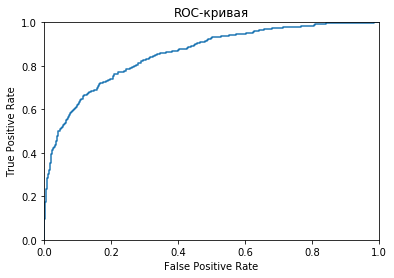

In [ ]:
probabilities_test = model_forest.predict_proba(X_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(y_test, probabilities_one_test)
print('auc_roc:', auc_roc)
fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test) 
plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show() 

Мы получили значение auc-roc 0,86 - это намного лучше слуйчайной модели (0,5). Мы не зря старались). Так можно найти баланс между TPR и FPR. Но я предлагаю сделать это подбором порога, так как нам важно сохранить метрику на уровне 0,59.

We got an auc-roc value of 0.86, which is much better than the random model (0.5). We have not tried in vain). So you can find a balance between TPR and FPR. But I suggest doing this by thresholding, since it is important for us to keep the metric at 0.59.

In [ ]:
for threshold in np.arange(0.3, 0.4, 0.01):
    predicted_test = probabilities_one_test > threshold 
    precision = precision_score(y_test, predicted_test) 
    recall = recall_score(y_test, predicted_test) 
    f1 = f1_score(y_test, predicted_test) 
    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, F1 = {:.3f}".format(
        threshold, precision, recall, f1))

Порог = 0.30 | Точность = 0.418, Полнота = 0.821, F1 = 0.554
Порог = 0.31 | Точность = 0.427, Полнота = 0.801, F1 = 0.557
Порог = 0.32 | Точность = 0.437, Полнота = 0.789, F1 = 0.563
Порог = 0.33 | Точность = 0.450, Полнота = 0.776, F1 = 0.569
Порог = 0.34 | Точность = 0.462, Полнота = 0.771, F1 = 0.578
Порог = 0.35 | Точность = 0.472, Полнота = 0.764, F1 = 0.583
Порог = 0.36 | Точность = 0.483, Полнота = 0.759, F1 = 0.590
Порог = 0.37 | Точность = 0.482, Полнота = 0.740, F1 = 0.584
Порог = 0.38 | Точность = 0.496, Полнота = 0.730, F1 = 0.590
Порог = 0.39 | Точность = 0.507, Полнота = 0.725, F1 = 0.597
Порог = 0.40 | Точность = 0.519, Полнота = 0.722, F1 = 0.604


Я бы предложил компании поставить порог отсечения на 0.38, так мы промаксимизируем полноту при минимально допустимой F-мере. 

I would suggest to the company to set the cutoff to 0.38, so we will maximize recall with the minimum allowed F-measure.

In [ ]:
predicted_test = probabilities_one_test > 0.38
print(f1_score(y_test, predicted_test))
confusion_matrix(y_test, predicted_test)

0.5904572564612327


array([[1291,  302],
       [ 110,  297]])

Таким образом мы выявим большее колчество тех, кто может отказать. В этом случае, мы выявлил еще 40 таких клинетов (256 при стандартном пороге, 296 - при измененном). При этом, конечно, выросло и число FP. В нашем случае почти в два раза (со 165 до 309). Имея данные о стоимости привлечения нового клиента и стоймости "обхаживания" старого, можно решить стоит ли применять такой порог.

Thus, we will identify a greater number of those who can refuse. In this case, we identified 40 more such clients (256 with the standard threshold, 296 with the modified threshold). At the same time, of course, the number of FPs also increased. In our case, almost twice (from 165 to 309). Given the cost of acquiring a new customer and the cost of wooing an old one, one can decide whether to apply such a threshold.

### <div class="alert alert-info">Второй способ тестрирования.</div>

### <div class="alert alert-info">Second way of testing.</div>

Станадртизируем тестовую выборку.

We standardize the test sample.

In [ ]:
X_test_scaled = scaler.transform(X_test) 

Объединим обучающую и тестовую выборки.

Combine the training and test sets.

In [ ]:
X_concatenated = np.concatenate((X_train_scaled, X_valid_scaled),axis=0)

In [ ]:
y_concatenated = np.concatenate((y_train, y_valid), axis=0)

In [ ]:
model_forest = RandomForestClassifier(random_state=42, max_depth=11, criterion='entropy', 
                                                  n_estimators=60, class_weight='balanced')
model_forest.fit(X_concatenated, y_concatenated)
prediction = model_forest.predict(X_test_scaled)
result = f1_score(prediction, y_test)
print(result)

0.6181818181818183


Также получили неплохой результат.

We also got good results.

### Общий вывод:
- Мы изучили и подготовили данные;
- Провели тест моделей без балансировки классов и выбрали случайный лес в качестве рабочей модели;
- Провели тест способов балансировки для обучения моделей и выбрали метод взвешивания классов;
- Испытали модель на тестовой выборке и получили результат чуть выше требуемого - 0.63 (F-мера);
- Дали рекомендации по использованию модели (установление порога отсечения на уровне 0,38). 

### General conclusion:
- We studied and prepared the data;
- Conducted a test of models without class balancing and chose a random forest as a working model;
- Conducted a test of balancing methods for training models and chose a class weighting method;
- We tested the model on a test sample and got a result slightly higher than the required one - 0.63 (F-measure);
- Gave recommendations on the use of the model (setting the cut-off threshold at 0.38).